# SportsMOT - EDA

Исследование датасета https://www.kaggle.com/datasets/ayushspai/sportsmot - 80 клипов из записей футбольного матча.

## 1. Setup and Imports

In [1]:
%matplotlib inline
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from pathlib import Path
from collections import Counter, defaultdict
import seaborn as sns
from PIL import Image
import cv2

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

## 2. Load Dataset

In [2]:
mot_dir = Path('./SportsMOT/sportsmot_publish/dataset')
data_dir = mot_dir / 'converted_labels/coco'
img_dir = mot_dir / 'train'

datasets = {}
for split in ['train', 'valid', 'test']:
    with open(data_dir / f'{split}.json') as f:
        datasets[split] = json.load(f)
    print(f"{split}: {len(datasets[split]['images'])} images, {len(datasets[split]['annotations'])} annotations")

coco_data = datasets['train']
IMG_WIDTH = coco_data['images'][0]['width']
IMG_HEIGHT = coco_data['images'][0]['height']
print(f"Image size: {IMG_WIDTH}x{IMG_HEIGHT}")

train: 11113 images, 145228 annotations
valid: 9058 images, 117115 annotations
test: 33742 images, 0 annotations
Image size: 1280x720


## 3. Dataset Overview

In [3]:
# print(f"Version: {coco_data['info']['version']}")
print(f"Categories: {', '.join([cat['name'] for cat in coco_data['categories']])}")

for split, data in datasets.items():
    n_imgs, n_anns = len(data['images']), len(data['annotations'])
    print(f"{split}: {n_imgs:,} images, {n_anns:,} annotations ({n_anns/n_imgs:.1f} per image)")

Categories: pedestrian
train: 11,113 images, 145,228 annotations (13.1 per image)
valid: 9,058 images, 117,115 annotations (12.9 per image)
test: 33,742 images, 0 annotations (0.0 per image)


#### Теперь не имеем разделения по игрокам/вратарям/рефери (категорию `pedestrian` тут вписал MOT->COCO конвертатор, который к датасету прилагался)
#### Число кадров в трейне и валидации плюс минус одинаковое, в тесте уже в >3 раза больше
#### Примерно схожее число аннотаций в трейне и валидации

## 4. Category Distribution

In [4]:
# category_counts = Counter([ann['category_id'] for ann in coco_data['annotations']])
category_names = {cat['id']: cat['name'] for cat in coco_data['categories']}

# categories = [category_names[cid] for cid in sorted(category_counts.keys())]
# counts = [category_counts[cid] for cid in sorted(category_counts.keys())]

# fig, ax = plt.subplots(figsize=(10, 5))
# colors = ['#3498db', '#2ecc71', '#e74c3c']
# ax.bar(categories, counts, color=colors, alpha=0.7)
# ax.set_ylabel('Count')
# ax.set_title('Annotations by Category')
# for i, count in enumerate(counts):
#     ax.text(i, count, f'{count:,}', ha='center', va='bottom')
# plt.show()

# for cat_id in sorted(category_counts.keys()):
#     count = category_counts[cat_id]
#     pct = count / len(coco_data['annotations']) * 100
#     print(f"{category_names[cat_id]}: {count:,} ({pct:.1f}%)")

## 5. Bounding Box Analysis

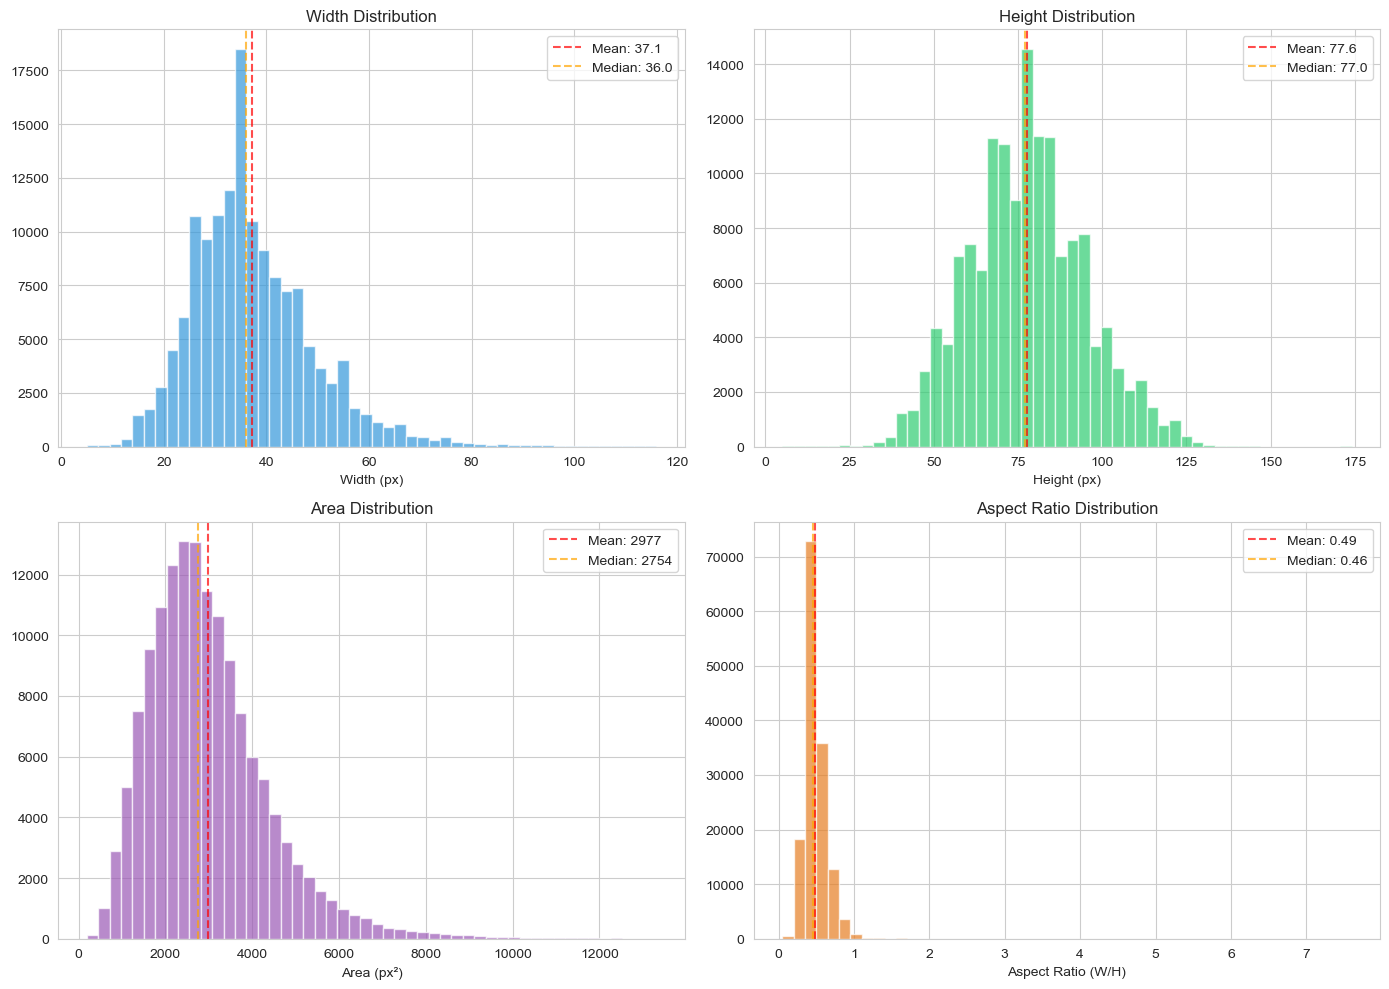

Width: 37.1±11.8 px
Height: 77.6±17.2 px
Area: 2977±1395 px²
Aspect ratio: 0.49±0.15


In [5]:
bbox_widths = []
bbox_heights = []
bbox_areas = []
bbox_aspect_ratios = []

for ann in coco_data['annotations']:
    bbox = ann['bbox']
    w, h = bbox[2], bbox[3]
    bbox_widths.append(w)
    bbox_heights.append(h)
    bbox_areas.append(ann['area'])
    bbox_aspect_ratios.append(w / h if h > 0 else 0)

bbox_widths = np.array(bbox_widths)
bbox_heights = np.array(bbox_heights)
bbox_areas = np.array(bbox_areas)
bbox_aspect_ratios = np.array(bbox_aspect_ratios)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].hist(bbox_widths, bins=50, alpha=0.7, color='#3498db')
axes[0, 0].axvline(np.mean(bbox_widths), color='red', linestyle='--', alpha=0.7, label=f'Mean: {np.mean(bbox_widths):.1f}')
axes[0, 0].axvline(np.median(bbox_widths), color='orange', linestyle='--', alpha=0.7, label=f'Median: {np.median(bbox_widths):.1f}')
axes[0, 0].set_xlabel('Width (px)')
axes[0, 0].set_title('Width Distribution')
axes[0, 0].legend()

axes[0, 1].hist(bbox_heights, bins=50, alpha=0.7, color='#2ecc71')
axes[0, 1].axvline(np.mean(bbox_heights), color='red', linestyle='--', alpha=0.7, label=f'Mean: {np.mean(bbox_heights):.1f}')
axes[0, 1].axvline(np.median(bbox_heights), color='orange', linestyle='--', alpha=0.7, label=f'Median: {np.median(bbox_heights):.1f}')
axes[0, 1].set_xlabel('Height (px)')
axes[0, 1].set_title('Height Distribution')
axes[0, 1].legend()

axes[1, 0].hist(bbox_areas, bins=50, alpha=0.7, color='#9b59b6')
axes[1, 0].axvline(np.mean(bbox_areas), color='red', linestyle='--', alpha=0.7, label=f'Mean: {np.mean(bbox_areas):.0f}')
axes[1, 0].axvline(np.median(bbox_areas), color='orange', linestyle='--', alpha=0.7, label=f'Median: {np.median(bbox_areas):.0f}')
axes[1, 0].set_xlabel('Area (px²)')
axes[1, 0].set_title('Area Distribution')
axes[1, 0].legend()

axes[1, 1].hist(bbox_aspect_ratios, bins=50, alpha=0.7, color='#e67e22')
axes[1, 1].axvline(np.mean(bbox_aspect_ratios), color='red', linestyle='--', alpha=0.7, label=f'Mean: {np.mean(bbox_aspect_ratios):.2f}')
axes[1, 1].axvline(np.median(bbox_aspect_ratios), color='orange', linestyle='--', alpha=0.7, label=f'Median: {np.median(bbox_aspect_ratios):.2f}')
axes[1, 1].set_xlabel('Aspect Ratio (W/H)')
axes[1, 1].set_title('Aspect Ratio Distribution')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print(f"Width: {np.mean(bbox_widths):.1f}±{np.std(bbox_widths):.1f} px")
print(f"Height: {np.mean(bbox_heights):.1f}±{np.std(bbox_heights):.1f} px")
print(f"Area: {np.mean(bbox_areas):.0f}±{np.std(bbox_areas):.0f} px²")
print(f"Aspect ratio: {np.mean(bbox_aspect_ratios):.2f}±{np.std(bbox_aspect_ratios):.2f}")

#### В целом распределения вроде плюс-минус как у SoccerNet
#### Абсолютные размеры боксов выходят чуть поменьше (в 1.29 раз примерно) за счет того, что теперь кадры не 1920x1080, а 1280x720. Хотя 1280/720 = 1.5, то есть относительные размеры боксов здесь как будто побольше выходят

## 5.1. Object Location Analysis (Heatmap)

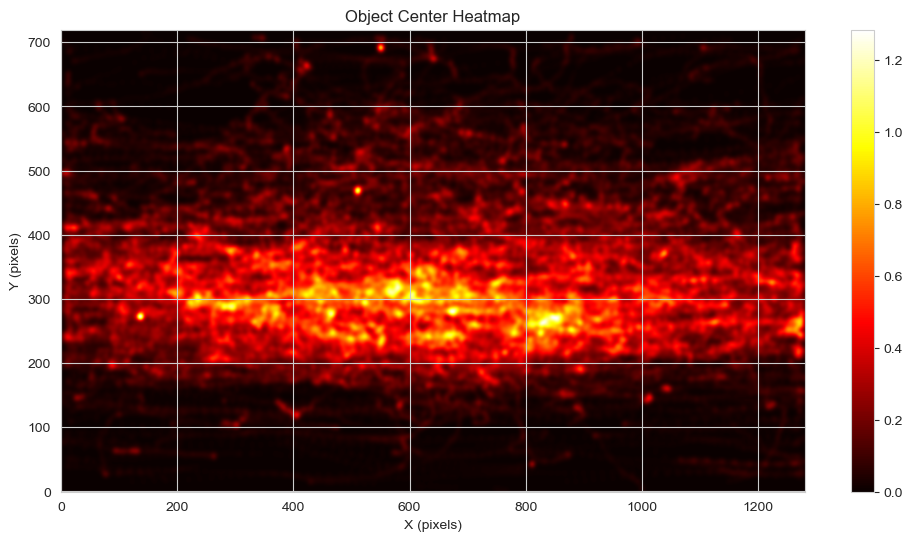

Peak density at y=301 (42% from top)
Top: 68.5%, Bottom: 31.5%


In [6]:
heatmap = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.float32)

for ann in coco_data['annotations']:
    bbox = ann['bbox']
    cx = int(bbox[0] + bbox[2] / 2)
    cy = int(bbox[1] + bbox[3] / 2)
    # cx = np.clip(cx, 0, IMG_WIDTH - 1)        # как-то я не разобрался в итоге, когда это может реально пригодиться, но без этого хитмапа составляется где-то в 5 раз быстрее
    # cy = np.clip(cy, 0, IMG_HEIGHT - 1)
    heatmap[cy, cx] += 1

# heatmap_smoothed = cv2.GaussianBlur(heatmap, (51, 51), 0)
heatmap_smoothed = cv2.GaussianBlur(heatmap, (25, 25), 0)

fig, ax = plt.subplots(figsize=(12, 6))
im = ax.imshow(heatmap_smoothed, cmap='hot', aspect='auto')
ax.set_title('Object Center Heatmap')
ax.set_xlabel('X (pixels)')
ax.set_ylabel('Y (pixels)')
plt.colorbar(im, ax=ax)
ax.invert_yaxis()
plt.show()

vertical_dist = np.sum(heatmap, axis=1)
peak_y = np.argmax(vertical_dist)
print(f"Peak density at y={peak_y} ({peak_y/IMG_HEIGHT*100:.0f}% from top)")

top_half = np.sum(heatmap[:IMG_HEIGHT//2, :])
bottom_half = np.sum(heatmap[IMG_HEIGHT//2:, :])
print(f"Top: {top_half/(top_half+bottom_half)*100:.1f}%, Bottom: {bottom_half/(top_half+bottom_half)*100:.1f}%")

#### Здесь наибольшая концентрация игроков приходится уже пониже того, что было в SoccerNet, и при этом вверху концентрация уже далеко не нулевая
#### Неизменной осталась крайне низкая концентрация в нижних 15% от кадра

## 5.2. Bounding Box to Frame Area Ratio Analysis

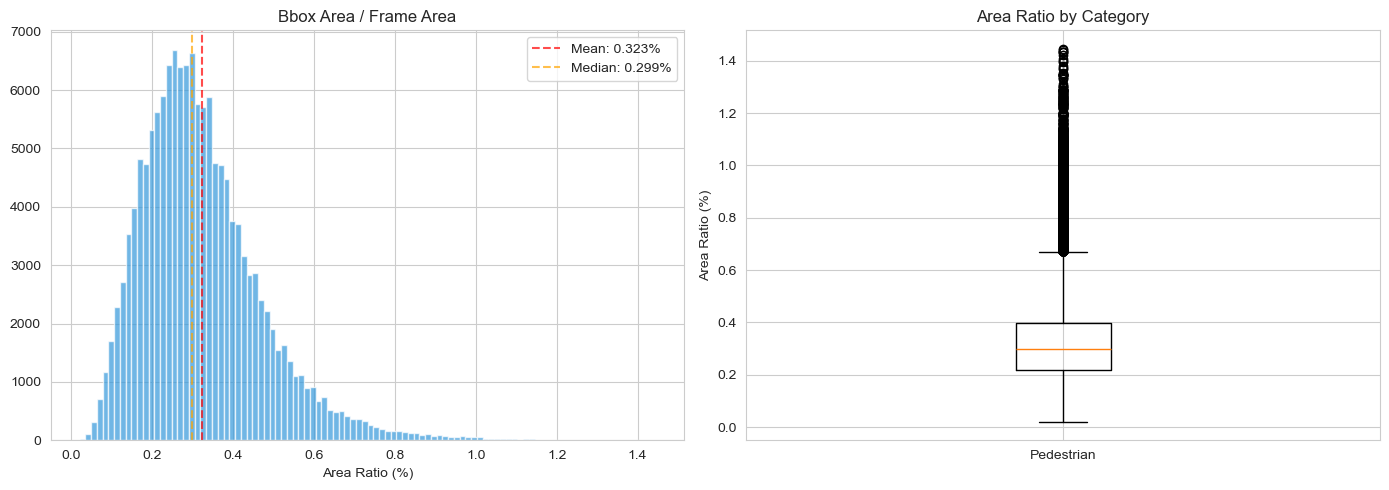

Mean: 0.323%, Median: 0.299%
Range: 0.0206% - 1.444%
Percentiles: 50th=0.299%, 95th=0.601%


In [7]:
frame_area = IMG_WIDTH * IMG_HEIGHT
area_ratios = []
area_ratios_by_category = defaultdict(list)

for ann in coco_data['annotations']:
    ratio = ann['area'] / frame_area * 100
    area_ratios.append(ratio)
    cat_name = category_names[ann['category_id']]
    area_ratios_by_category[cat_name].append(ratio)

area_ratios = np.array(area_ratios)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(area_ratios, bins=100, alpha=0.7, color='#3498db')
axes[0].axvline(np.mean(area_ratios), color='red', linestyle='--', alpha=0.7, label=f'Mean: {np.mean(area_ratios):.3f}%')
axes[0].axvline(np.median(area_ratios), color='orange', linestyle='--', alpha=0.7, label=f'Median: {np.median(area_ratios):.3f}%')
axes[0].set_xlabel('Area Ratio (%)')
axes[0].set_title('Bbox Area / Frame Area')
axes[0].legend()

data = [area_ratios_by_category[cat] for cat in sorted(area_ratios_by_category.keys())]
# axes[1].boxplot(data, labels=[cat.capitalize() for cat in sorted(area_ratios_by_category.keys())])
axes[1].boxplot(data, tick_labels=[cat.capitalize() for cat in sorted(area_ratios_by_category.keys())])
axes[1].set_ylabel('Area Ratio (%)')
axes[1].set_title('Area Ratio by Category')

plt.tight_layout()
plt.show()

print(f"Mean: {np.mean(area_ratios):.3f}%, Median: {np.median(area_ratios):.3f}%")
print(f"Range: {np.min(area_ratios):.4f}% - {np.max(area_ratios):.3f}%")
print(f"Percentiles: 50th={np.percentile(area_ratios, 50):.3f}%, 95th={np.percentile(area_ratios, 95):.3f}%")

## 5.3. Relative Width and Height Analysis

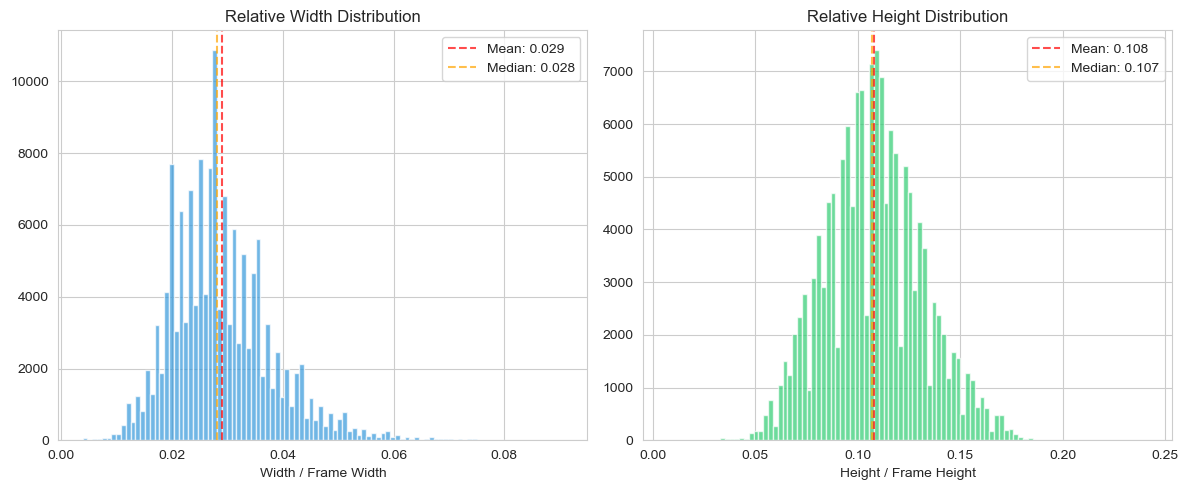

Width:  mean=0.029, median=0.028
Height: mean=0.108, median=0.107


In [8]:
width_ratios = []
height_ratios = []

for ann in coco_data['annotations']:
    bbox = ann['bbox']
    width_ratios.append(bbox[2] / IMG_WIDTH)
    height_ratios.append(bbox[3] / IMG_HEIGHT)

width_ratios = np.array(width_ratios)
height_ratios = np.array(height_ratios)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(width_ratios, bins=100, alpha=0.7, color='#3498db')
axes[0].axvline(np.mean(width_ratios), color='red', linestyle='--', alpha=0.7, label=f'Mean: {np.mean(width_ratios):.3f}')
axes[0].axvline(np.median(width_ratios), color='orange', linestyle='--', alpha=0.7, label=f'Median: {np.median(width_ratios):.3f}')
axes[0].set_xlabel('Width / Frame Width')
axes[0].set_title('Relative Width Distribution')
axes[0].legend()

axes[1].hist(height_ratios, bins=100, alpha=0.7, color='#2ecc71')
axes[1].axvline(np.mean(height_ratios), color='red', linestyle='--', alpha=0.7, label=f'Mean: {np.mean(height_ratios):.3f}')
axes[1].axvline(np.median(height_ratios), color='orange', linestyle='--', alpha=0.7, label=f'Median: {np.median(height_ratios):.3f}')
axes[1].set_xlabel('Height / Frame Height')
axes[1].set_title('Relative Height Distribution')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Width:  mean={np.mean(width_ratios):.3f}, median={np.median(width_ratios):.3f}")
print(f"Height: mean={np.mean(height_ratios):.3f}, median={np.median(height_ratios):.3f}")

## 5.4. Bounding Box Overlap Analysis (IoU)

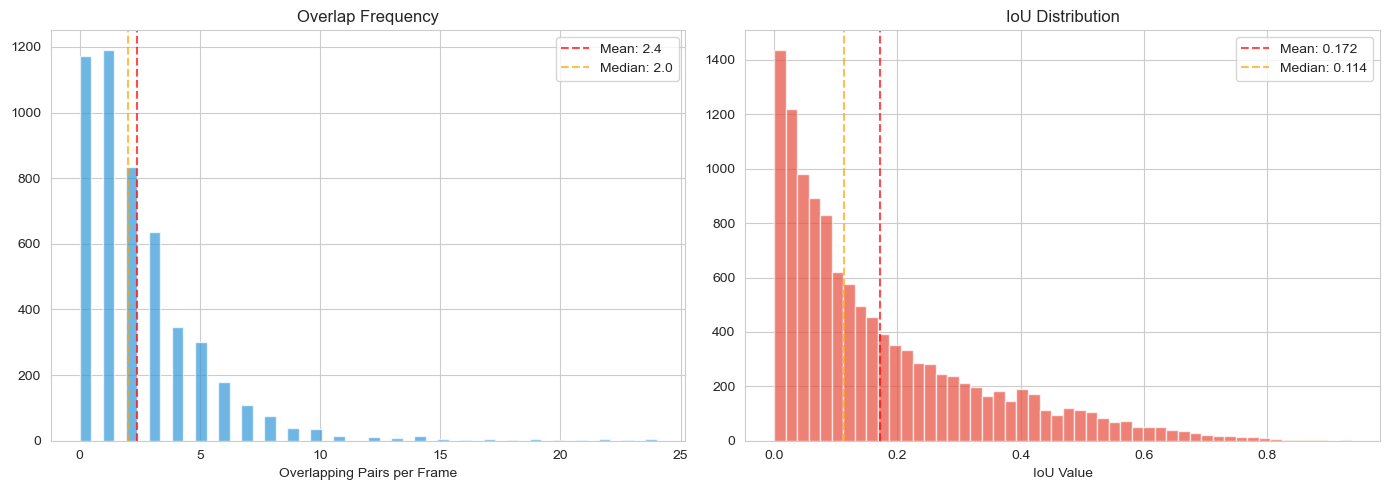

Analyzed 5000 frames, found 12,037 overlaps
Overlaps per frame: mean=2.4, max=24
IoU: mean=0.172, median=0.114
IoU percentiles: 50th=0.114, 75th=0.253, 95th=0.523


In [9]:
def calculate_iou(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    
    x_left = max(x1, x2)
    y_top = max(y1, y2)
    x_right = min(x1 + w1, x2 + w2)
    y_bottom = min(y1 + h1, y2 + h2)
    
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    
    intersection = (x_right - x_left) * (y_bottom - y_top)
    union = w1 * h1 + w2 * h2 - intersection
    
    return intersection / union if union > 0 else 0.0

ann_index = defaultdict(list)
for ann in coco_data['annotations']:
    ann_index[ann['image_id']].append(ann)

sample_size = min(5000, len(ann_index))
sampled_ids = np.random.choice(list(ann_index.keys()), sample_size, replace=False)

overlaps_per_frame = []
iou_values = []

for img_id in sampled_ids:
    anns = ann_index[img_id]
    if len(anns) < 2:
        overlaps_per_frame.append(0)
        continue
    
    bboxes = [ann['bbox'] for ann in anns]
    frame_overlaps = 0
    
    for i in range(len(bboxes)):
        for j in range(i + 1, len(bboxes)):
            iou = calculate_iou(bboxes[i], bboxes[j])
            if iou > 0:
                frame_overlaps += 1
                iou_values.append(iou)
    
    overlaps_per_frame.append(frame_overlaps)

overlaps_per_frame = np.array(overlaps_per_frame)
iou_values = np.array(iou_values)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(overlaps_per_frame, bins=50, alpha=0.7, color='#3498db')
axes[0].axvline(np.mean(overlaps_per_frame), color='red', linestyle='--', alpha=0.7, label=f'Mean: {np.mean(overlaps_per_frame):.1f}')
axes[0].axvline(np.median(overlaps_per_frame), color='orange', linestyle='--', alpha=0.7, label=f'Median: {np.median(overlaps_per_frame):.1f}')
axes[0].set_xlabel('Overlapping Pairs per Frame')
axes[0].set_title('Overlap Frequency')
axes[0].legend()

if len(iou_values) > 0:
    axes[1].hist(iou_values, bins=50, alpha=0.7, color='#e74c3c')
    axes[1].axvline(np.mean(iou_values), color='red', linestyle='--', alpha=0.7, label=f'Mean: {np.mean(iou_values):.3f}')
    axes[1].axvline(np.median(iou_values), color='orange', linestyle='--', alpha=0.7, label=f'Median: {np.median(iou_values):.3f}')
    axes[1].set_xlabel('IoU Value')
    axes[1].set_title('IoU Distribution')
    axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Analyzed {sample_size} frames, found {len(iou_values):,} overlaps")
print(f"Overlaps per frame: mean={np.mean(overlaps_per_frame):.1f}, max={np.max(overlaps_per_frame)}")
if len(iou_values) > 0:
    print(f"IoU: mean={np.mean(iou_values):.3f}, median={np.median(iou_values):.3f}")
    print(f"IoU percentiles: 50th={np.percentile(iou_values, 50):.3f}, 75th={np.percentile(iou_values, 75):.3f}, 95th={np.percentile(iou_values, 95):.3f}")

#### В среднем теперь 2.4 перекрытия на кадр, в SoccerNet было 4.2
#### По IoU практически ничего не изменилось

## 6. Objects per Image Analysis

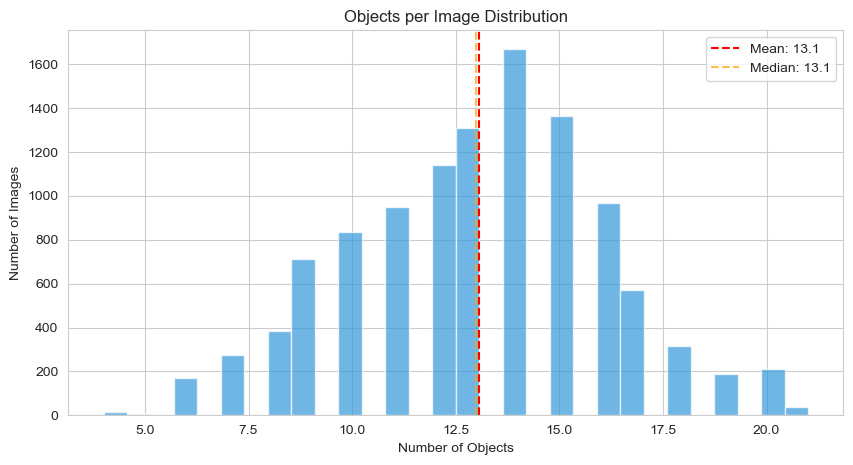

Objects per image: mean=13.1, median=13, max=21


In [10]:
objects_per_image = defaultdict(int)
for ann in coco_data['annotations']:
    objects_per_image[ann['image_id']] += 1

obj_counts = list(objects_per_image.values())

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(obj_counts, bins=30, alpha=0.7, color='#3498db')
ax.axvline(np.mean(obj_counts), color='red', linestyle='--', label=f'Mean: {np.mean(obj_counts):.1f}')
ax.axvline(np.median(obj_counts), color='orange', linestyle='--', alpha=0.7, label=f'Median: {np.mean(obj_counts):.1f}')
ax.set_xlabel('Number of Objects')
ax.set_ylabel('Number of Images')
ax.set_title('Objects per Image Distribution')
ax.legend()
plt.show()

print(f"Objects per image: mean={np.mean(obj_counts):.1f}, median={np.median(obj_counts):.0f}, max={np.max(obj_counts)}")

#### Здесь уже количество игроков в кадре стало 13 заместо 16, но и в целом игроков стало уже 21 заместо 25

## 7. Visualization Helper Functions


In [11]:
def visualize_image_with_annotations(image_info, annotations, img_dir, category_names):
    img_path = img_dir / image_info['file_name']
    if not img_path.exists():
        print(f"Image not found: {img_path}")
        return
    
    img = np.array(Image.open(img_path))
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img)
    
    colors = {1: '#3498db', 2: '#2ecc71', 3: '#e74c3c'}
    
    for ann in annotations:
        bbox = ann['bbox']
        cat_id = ann['category_id']
        
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3],
                                linewidth=2, edgecolor=colors.get(cat_id, 'yellow'), facecolor='none')
        ax.add_patch(rect)
        
        label = f"{category_names[cat_id]} (ID:{ann.get('track_id', '?')})"
        ax.text(bbox[0], bbox[1]-5, label, color='white', fontsize=9,
               bbox=dict(boxstyle='round,pad=0.3', facecolor=colors.get(cat_id, 'yellow'), alpha=0.8))
    
    ax.axis('off')
    ax.set_title(f"{image_info['file_name']} | {len(annotations)} objects")
    plt.tight_layout()
    plt.show()

## 8. Sample Image Visualization


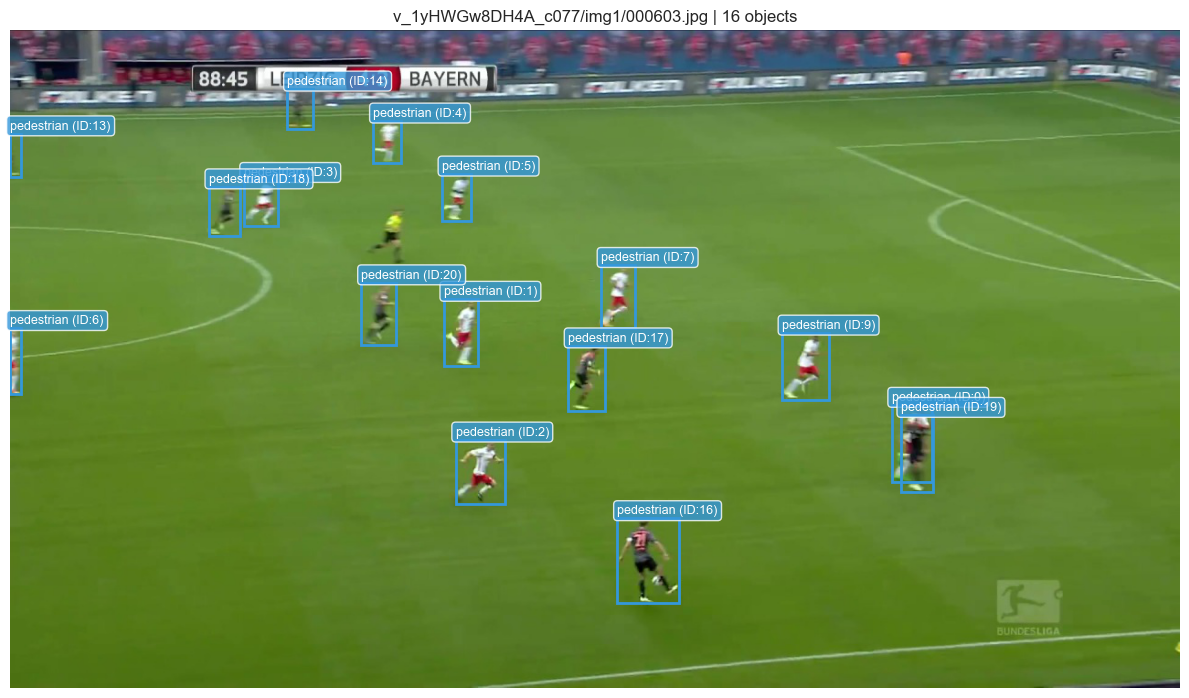

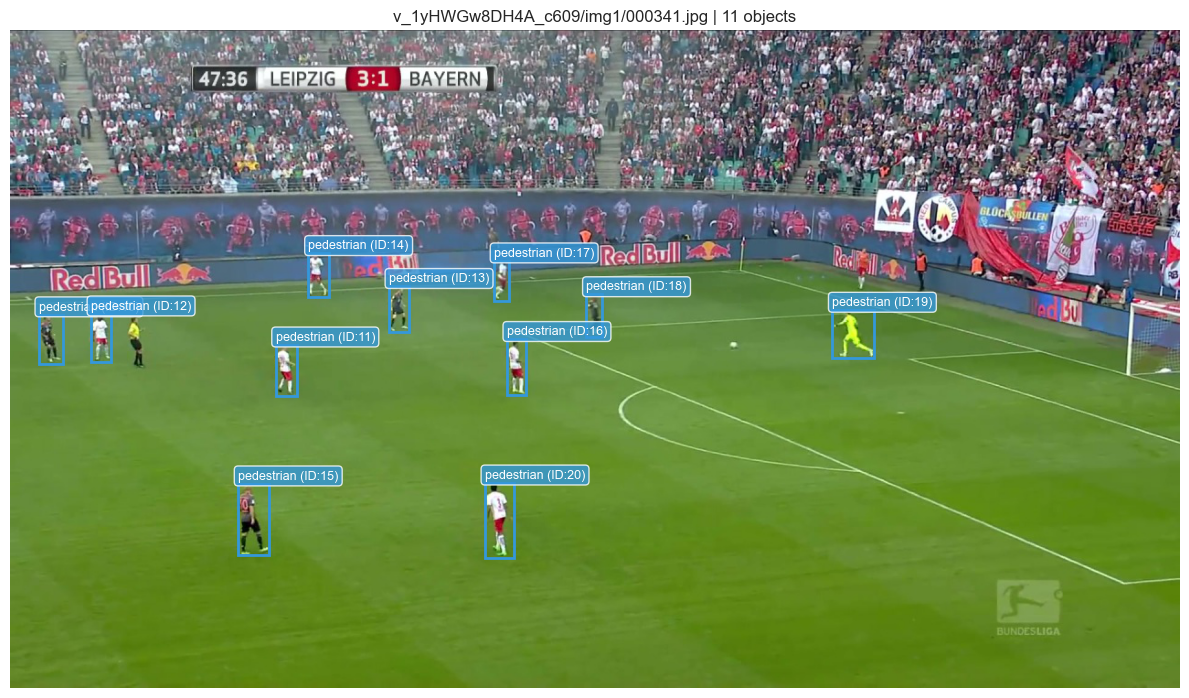

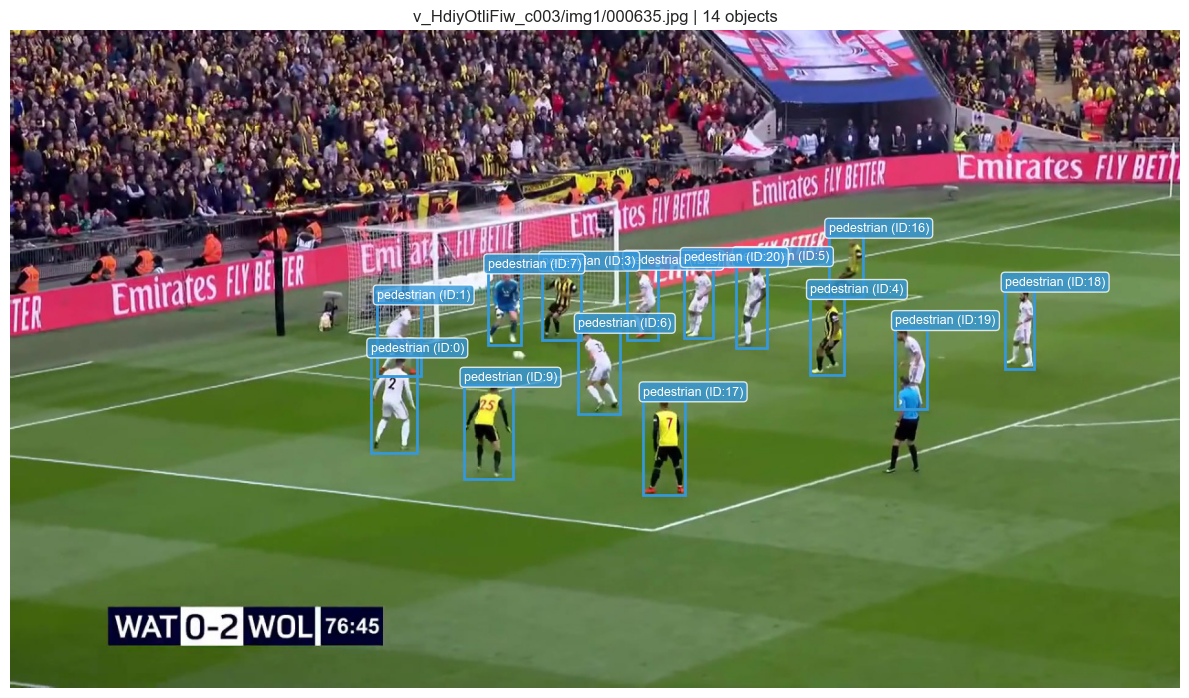

In [12]:
np.random.seed(42)

ann_index = defaultdict(list)
for ann in coco_data['annotations']:
    ann_index[ann['image_id']].append(ann)

images_with_anns = [img for img in coco_data['images'] if img['id'] in ann_index]
sample_images = np.random.choice(images_with_anns, 3, replace=False)

for img_info in sample_images:
    img_anns = ann_index[img_info['id']]
    visualize_image_with_annotations(img_info, img_anns, img_dir, category_names)

#### И вот тут я вдруг осознал, что, оказывается, для рефери так и вовсе боксов не имеется

## 9.1. Object Motion Analysis

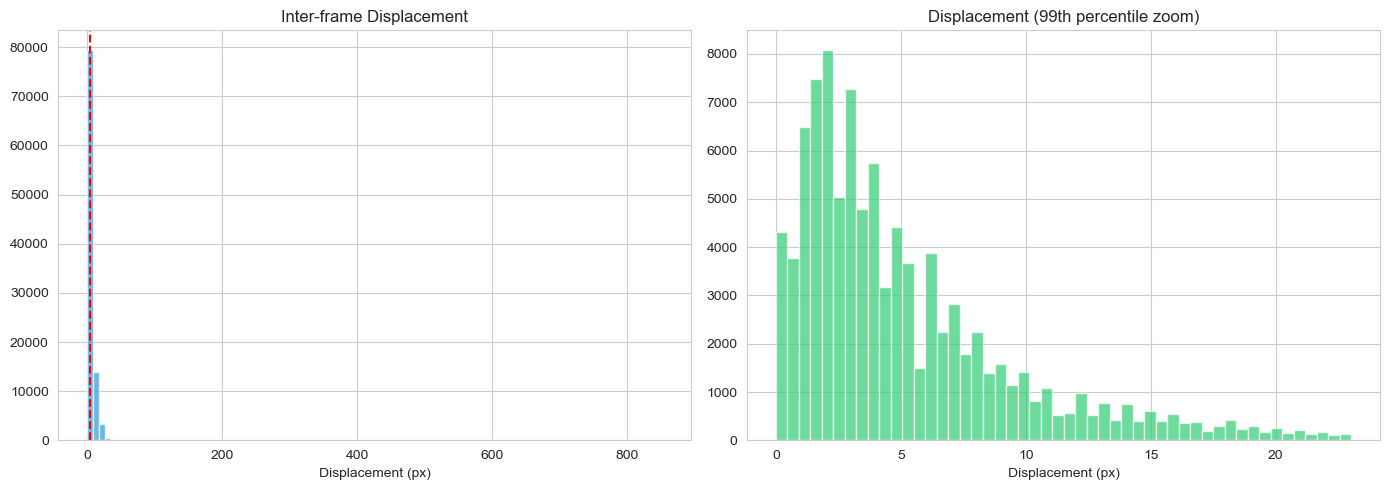

Analyzed 97,150 displacements from 22 tracks
Displacement: mean=5.4px, median=4.0px
Percentiles: 50th=4.0, 95th=16.0, 99th=23.0


In [13]:
motion_split = 'train'
mot_split_dir = mot_dir / motion_split

if not mot_split_dir.exists():
    print(f"MOT directory not found: {mot_split_dir}")
    print("Run: python convert_labels.py --format mot")
else:
    all_displacements = []
    track_velocities = defaultdict(list)
    
    sequence_dirs = sorted([d for d in mot_split_dir.iterdir() if d.is_dir()])[:10]
    
    for seq_dir in sequence_dirs:
        gt_file = seq_dir / 'gt' / 'gt.txt'
        if not gt_file.exists():
            continue
        
        mot_data = np.loadtxt(gt_file, delimiter=',')
        tracks = defaultdict(list)
        
        for row in mot_data:
            frame_num, track_id, x, y, w, h = row[:6]
            cx, cy = x + w/2, y + h/2
            tracks[int(track_id)].append((int(frame_num), cx, cy))
        
        for track_id, positions in tracks.items():
            positions = sorted(positions, key=lambda x: x[0])
            for i in range(len(positions) - 1):
                frame1, cx1, cy1 = positions[i]
                frame2, cx2, cy2 = positions[i + 1]
                if frame2 - frame1 == 1:
                    displacement = np.sqrt((cx2-cx1)**2 + (cy2-cy1)**2)
                    all_displacements.append(displacement)
                    track_velocities[track_id].append(displacement)
    
    all_displacements = np.array(all_displacements)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    axes[0].hist(all_displacements, bins=100, alpha=0.7, color='#3498db')
    axes[0].axvline(np.median(all_displacements), color='red', linestyle='--')
    axes[0].set_xlabel('Displacement (px)')
    axes[0].set_title('Inter-frame Displacement')
    
    reasonable = all_displacements[all_displacements < np.percentile(all_displacements, 99)]
    axes[1].hist(reasonable, bins=50, alpha=0.7, color='#2ecc71')
    axes[1].set_xlabel('Displacement (px)')
    axes[1].set_title('Displacement (99th percentile zoom)')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Analyzed {len(all_displacements):,} displacements from {len(track_velocities)} tracks")
    print(f"Displacement: mean={np.mean(all_displacements):.1f}px, median={np.median(all_displacements):.1f}px")
    print(f"Percentiles: 50th={np.percentile(all_displacements, 50):.1f}, 95th={np.percentile(all_displacements, 95):.1f}, 99th={np.percentile(all_displacements, 99):.1f}")

#### Похоже, движение здесь уже чуть менее плавное, в SoccerNet было медианно 3.5 пикселя за фрейм при размере 1920x1080, здесь уже 4.0 при размере 1280x720

## 9. Tracking ID Analysis

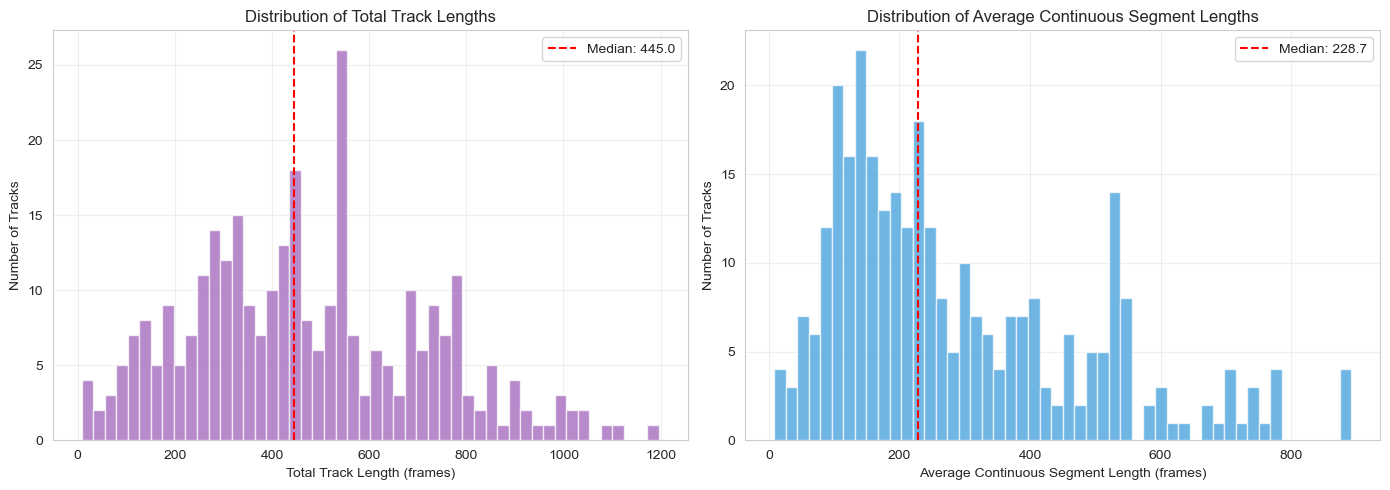

Analyzed 15 videos
Total number of tracks: 309

Total track length:
  Mean: 470.0 frames
  Median: 445.0 frames
  Min: 8, Max: 1196

Average continuous segment length per track:
  Mean: 289.0 frames
  Median: 228.7 frames
  Min: 8.0, Max: 892.0

Overall continuity ratio: 61.5%


In [14]:
# # Сопоставляем image_id с video_id
# image_to_video = {}
# for img in coco_data['images']:
#     video_id = img['file_name'].split('/')[1]
#     image_to_video[img['id']] = video_id

# image_to_frame = {}
# for img in coco_data['images']:
#     frame_num = int(img['file_name'].split('/')[-1].split('.')[0])
#     image_to_frame[img['id']] = frame_num

# # Собираем данные по трекам для каждого видео
# video_tracks = defaultdict(lambda: defaultdict(list))

# for ann in coco_data['annotations']:
#     image_id = ann['image_id']
#     track_id = ann.get('track_id', -1)
#     video_id = image_to_video.get(image_id, 'unknown')
#     frame_num = image_to_frame.get(image_id)
    
#     if frame_num is not None:
#         video_tracks[video_id][track_id].append(frame_num)

# Собираем данные по трекам для каждого видео
video_tracks = defaultdict(lambda: defaultdict(list))

for ann in coco_data['annotations']:
    track_id = ann.get('track_id', -1)
    image_id = ann['image_id']
    image_data = coco_data['images'][image_id-1]
    video_id = image_data['video_id']
    frame_num = image_data['frame_id']
    
    if frame_num is not None:
        video_tracks[video_id][track_id].append(frame_num)

all_track_lengths = []  # Общая длина каждого трека
all_avg_continuous_lengths = []  # Средняя длина непрерывных цепочек для каждого трека

for video_id, tracks in video_tracks.items():
    for track_id, frames in tracks.items():
        if track_id == -1:
            continue
            
        # Общая длина трека
        total_length = len(frames)
        all_track_lengths.append(total_length)
        
        # Находим непрерывные цепочки
        frames_sorted = sorted(frames)
        continuous_segments = []
        current_segment_length = 1
        
        for i in range(1, len(frames_sorted)):
            if frames_sorted[i] == frames_sorted[i-1] + 1:
                current_segment_length += 1
            else:
                continuous_segments.append(current_segment_length)
                current_segment_length = 1
        continuous_segments.append(current_segment_length)
        
        # Средняя длина всех непрерывных сегментов для этого трека
        avg_continuous_for_track = np.mean(continuous_segments)
        all_avg_continuous_lengths.append(avg_continuous_for_track)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# График 1: Общая длина треков
axes[0].hist(all_track_lengths, bins=50, alpha=0.7, color='#9b59b6')
axes[0].axvline(np.median(all_track_lengths), color='red', linestyle='--', label=f'Median: {np.median(all_track_lengths):.1f}')
axes[0].set_xlabel('Total Track Length (frames)')
axes[0].set_ylabel('Number of Tracks')
axes[0].set_title('Distribution of Total Track Lengths')
axes[0].legend()
axes[0].grid(alpha=0.3)

# График 2: Средняя длина непрерывных сегментов
axes[1].hist(all_avg_continuous_lengths, bins=50, alpha=0.7, color='#3498db')
axes[1].axvline(np.median(all_avg_continuous_lengths), color='red', linestyle='--', label=f'Median: {np.median(all_avg_continuous_lengths):.1f}')
axes[1].set_xlabel('Average Continuous Segment Length (frames)')
axes[1].set_ylabel('Number of Tracks')
axes[1].set_title('Distribution of Average Continuous Segment Lengths')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Analyzed {len(video_tracks)} videos")
print(f"Total number of tracks: {len(all_track_lengths)}")
print(f"\nTotal track length:")
print(f"  Mean: {np.mean(all_track_lengths):.1f} frames")
print(f"  Median: {np.median(all_track_lengths):.1f} frames")
print(f"  Min: {np.min(all_track_lengths)}, Max: {np.max(all_track_lengths)}")
print(f"\nAverage continuous segment length per track:")
print(f"  Mean: {np.mean(all_avg_continuous_lengths):.1f} frames")
print(f"  Median: {np.median(all_avg_continuous_lengths):.1f} frames")
print(f"  Min: {np.min(all_avg_continuous_lengths):.1f}, Max: {np.max(all_avg_continuous_lengths):.1f}")
print(f"\nOverall continuity ratio: {np.mean(all_avg_continuous_lengths) / np.mean(all_track_lengths) * 100:.1f}%")

#### Прикольно, что отношение средней длины непрерывного трека к просто средней длине трека, 289.0/470.0 ≈ 0.615, снова получилось примерно как отношение среднего количества боксов на кадре к количеству боксов в целом, 13/21 ≈ 0,619

## 10. Cross-Split Comparison


d:\anaconda3\envs\soccer_eda\lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\anaconda3\envs\soccer_eda\lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


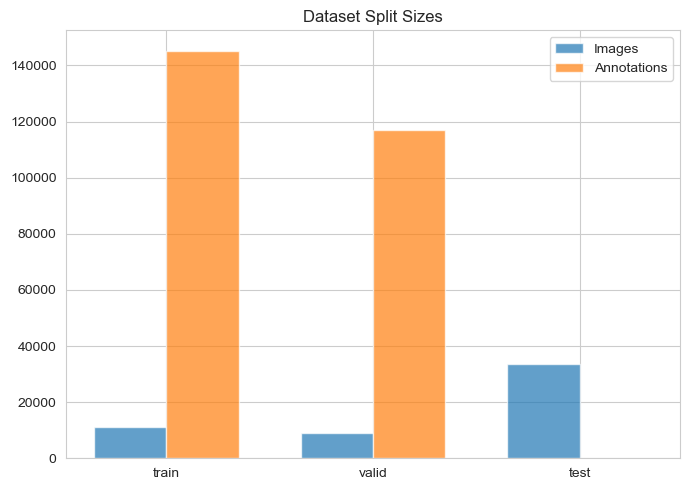

train: 11_113 imgs, 145_228 anns, 13.1 obj/img
valid: 9_058 imgs, 117_115 anns, 12.9 obj/img


In [21]:
split_stats = {}

for split_name, split_data in datasets.items():
    n_images = len(split_data['images'])
    n_annotations = len(split_data['annotations'])
    cat_counts = Counter([ann['category_id'] for ann in split_data['annotations']])
    
    obj_per_img = defaultdict(int)
    for ann in split_data['annotations']:
        obj_per_img[ann['image_id']] += 1
    
    split_stats[split_name] = {
        'images': n_images,
        'annotations': n_annotations,
        'players': cat_counts.get(1, 0),
        'goalkeepers': cat_counts.get(2, 0),
        'referees': cat_counts.get(3, 0),
        'avg_per_img': np.mean(list(obj_per_img.values()))
    }

# fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
splits = ['train', 'valid', 'test']

# Images and annotations
# ax = axes[0]
x = np.arange(len(splits))
width = 0.35
images = [split_stats[s]['images'] for s in splits]
anns = [split_stats[s]['annotations'] for s in splits]  # scale for visibility
ax.bar(x - width/2, images, width, label='Images', alpha=0.7)
ax.bar(x + width/2, anns, width, label='Annotations', alpha=0.7)
ax.set_xticks(x)
ax.set_xticklabels(splits)
ax.set_title('Dataset Split Sizes')
ax.legend()

# # Category distribution
# ax = axes[1]
# width = 0.25
# players = [split_stats[s]['players'] for s in splits]
# gk = [split_stats[s]['goalkeepers'] for s in splits]
# refs = [split_stats[s]['referees'] for s in splits]
# ax.bar(x - width, players, width, label='Players', color='#3498db', alpha=0.7)
# ax.bar(x, gk, width, label='Goalkeepers', color='#2ecc71', alpha=0.7)
# ax.bar(x + width, refs, width, label='Referees', color='#e74c3c', alpha=0.7)
# ax.set_xticks(x)
# ax.set_xticklabels(splits)
# ax.set_title('Category Distribution')
# ax.legend()

plt.tight_layout()
plt.show()

# for split in splits:
for split in splits[:2]:
    s = split_stats[split]
    # print(f"{split}: {s['images']:,} imgs, {s['annotations']:,} anns (P:{s['players']:,} GK:{s['goalkeepers']:,} R:{s['referees']:,}), {s['avg_per_img']:.1f} obj/img")
    print(f"{split}: {s['images']:_} imgs, {s['annotations']:_} anns, {s['avg_per_img']:.1f} obj/img")

## 11. Interactive Visualization (Custom Image)


In [16]:
sample_ids = sorted([img['id'] for img in coco_data['images']])[:10]
print(f"Sample image IDs: {sample_ids}")
print(f"Total images: {len(coco_data['images'])}")

Sample image IDs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Total images: 11113


Image ID 333: v_1yHWGw8DH4A_c029/img1/000333.jpg (17 annotations)


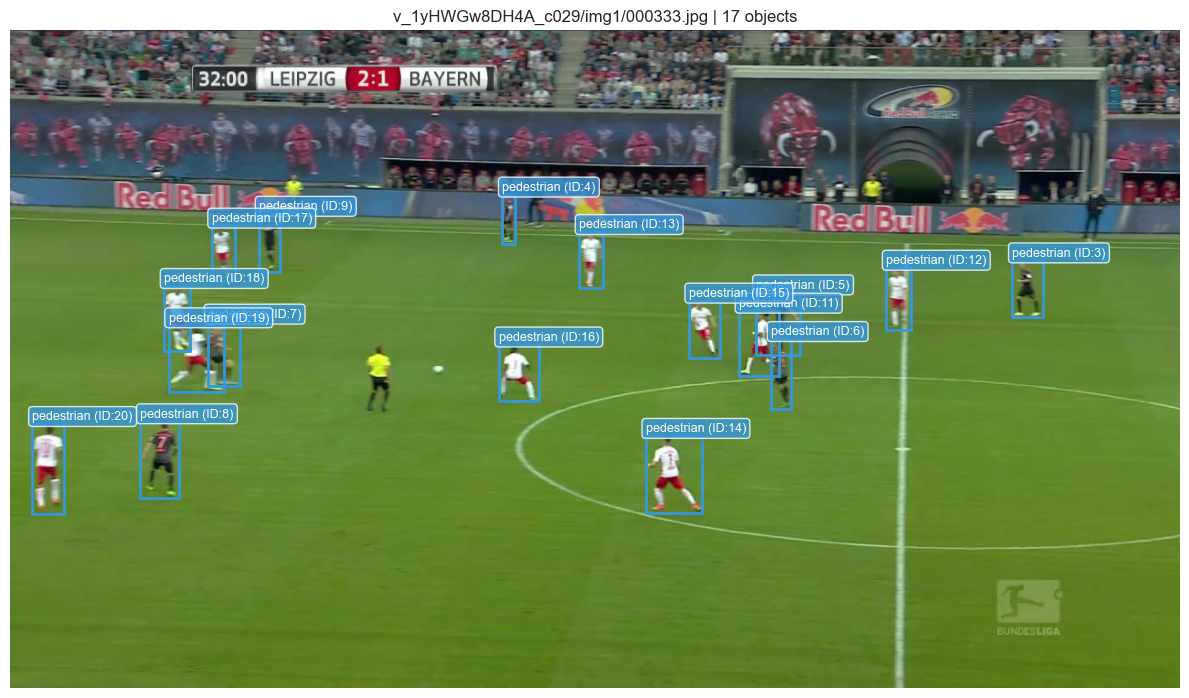

In [24]:
selected_image_id = 333

selected_img = next((img for img in coco_data['images'] if img['id'] == selected_image_id), None)

if selected_img:
    if 'ann_index' not in locals():
        ann_index = defaultdict(list)
        for ann in coco_data['annotations']:
            ann_index[ann['image_id']].append(ann)
    
    selected_anns = ann_index.get(selected_image_id, [])
    print(f"Image ID {selected_image_id}: {selected_img['file_name']} ({len(selected_anns)} annotations)")
    visualize_image_with_annotations(selected_img, selected_anns, img_dir, category_names)
else:
    print(f"Image ID {selected_image_id} not found")